In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn.metrics import r2_score, mean_absolute_error
from gpytorch.mlls import ExactMarginalLogLikelihood
import gpytorch
import altair as alt
import matplotlib.pyplot as plt
import re
from scipy.stats import norm
import os

UTILITY

In [2]:
def plot_gp_mean_with_uncertainty(candidates, mean, var, iteration, label="target_value", save=False, fname_prefix="gp_mean"):
    """
    Plottet pro Iteration die GP-Vorhersage (Mean) über alle Kandidaten-Strukturen
    inkl. Unsicherheitsband (±1σ).

    Args:
        candidates (pd.DataFrame): candidates, in exakt der Reihenfolge wie test_x berechnet wurde
        mean (torch.Tensor): prediction.mean (shape [N])
        var (torch.Tensor): prediction.variance (shape [N])
        iteration (int): Iterationsnummer für Titel/Dateiname
        label (str): Labelname (nur für Titel)
        save (bool): falls True, speichert PNG
        fname_prefix (str): Dateiprefix falls save=True
    """
    # --- to numpy ---
    mean_np = mean.detach().cpu().numpy().flatten()
    var_np  = var.detach().cpu().numpy().flatten()
    std_np  = np.sqrt(var_np)
    std_np  = np.maximum(std_np, 1e-12)  # Schutz gegen 0

    # --- Länge angleichen (robust gegen Drift) ---
    n = min(len(candidates), len(mean_np), len(std_np))
    mean_np = mean_np[:n]
    std_np  = std_np[:n]
    candidates_plot = candidates.iloc[:n]

    x = np.arange(n)
    names = candidates_plot["structure_name"].values if "structure_name" in candidates_plot.columns else None

    plt.figure(figsize=(12, 4.5))
    plt.plot(x, mean_np, label="Predicted mean")
    plt.fill_between(x, mean_np - std_np, mean_np + std_np, alpha=0.3, label="±1σ")

    plt.title(f"Iteration {iteration}: GP mean ± 1σ over candidates")
    plt.xlabel("Candidate index")
    plt.ylabel(r"GP prediction Adsorption $N^{UC}/V^{UC}\;[N/\mathrm{\AA}^3]$")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # optional: Namen (sparsam)
    if names is not None:
        if n <= 30:
            plt.xticks(x, names, rotation=90)
        else:
            step = max(1, n // 30)
            plt.xticks(x[::step], names[::step], rotation=90)

    if save:
        plt.savefig(f"{fname_prefix}_iter_{iteration:03d}_400.png", dpi=200, bbox_inches="tight")

    plt.show()


In [3]:
def plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration, label="target_value"):
    # --- Fix: Längen angleichen ---
    n = min(len(candidates), len(mean_np), len(std_np), len(ei_np), len(pi_np))
    candidates = candidates.iloc[:n].copy()
    mean_np = mean_np[:n]
    std_np  = std_np[:n]
    ei_np   = ei_np[:n]
    pi_np   = pi_np[:n]

    x = np.arange(len(candidates))  # Struktur-Index
    names = candidates["structure_name"].values

    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    plt.subplots_adjust(hspace=0.3)

    axs[0].plot(x, mean_np, color="C0", label="Predicted Mean")
    axs[0].fill_between(x, mean_np - std_np, mean_np + std_np, color="C0", alpha=0.3, label="Uncertainty (±1σ)")
    axs[0].set_ylabel("Predicted Mean")
    axs[0].set_title(f"Iteration {iteration}: GP Prediction (mean ± std)")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    axs[1].plot(x, ei_np, color="C1")
    axs[1].set_ylabel("Expected Improvement")
    axs[1].set_title("Expected Improvement over Candidates")
    axs[1].grid(alpha=0.3)

    axs[2].plot(x, pi_np, color="C2")
    axs[2].set_ylabel("Probability of Improvement")
    axs[2].set_xlabel("Candidate Structure Index")
    axs[2].set_title("Probability of Improvement")
    axs[2].grid(alpha=0.3)

    if len(names) <= 30:
        axs[2].set_xticks(x)
        axs[2].set_xticklabels(names, rotation=90)
    else:
        step = max(1, len(names)//30)
        axs[2].set_xticks(x[::step])
        axs[2].set_xticklabels(names[::step], rotation=90)

    plt.tight_layout()
    #plt.savefig("BO_BO_BO_BO.png", dpi=300, bbox_inches="tight")
    plt.show()


In [4]:
def is_bin_column(col) -> bool:
    """
    True für:
      - 'bin_0', 'bin_1', ... (beliebige nichtnegative Integer)
      - auch für numerische Spaltennamen wie 0, 1, '0', '1' (optional nützlich)
    """
    # numerische Spaltennamen zulassen (z. B. 0, 1, 2)
    if isinstance(col, (int, np.integer)):
        return True

    s = str(col)
    if s.isdigit():                 # '0', '1', ...
        return True
    if re.fullmatch(r"bin_\d+", s): # 'bin_0', 'bin_1', ...
        return True
    return False

MODELL GP

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp(xt_train, yt_train, training_iterations=100):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(xt_train, yt_train, likelihood)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
    mll = ExactMarginalLogLikelihood(likelihood, model)

    losses = []

    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(xt_train)
        loss = -mll(output, yt_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    return model.eval(), likelihood.eval(), losses

DATEN EINLESEN & FILTERN

In [6]:
dft_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/dft_data_temp_pressure_swingswingswing.csv")
#dft_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/dft_data_temp_pressure_präsi_20bin.csv")

dft_data["density_bulk"] = (
    dft_data["density_bulk"]
    .astype(str)                            # sicherstellen, dass alles string ist
    .str.strip()                             # Leerzeichen weg
    .str.replace('[', '', regex=False)       # "[" entfernen
    .str.replace(']', '', regex=False)       # "]" entfernen
)
dft_data["density_bulk"] = pd.to_numeric(dft_data["density_bulk"], errors="coerce")
#expV_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_hist_no_pressure_no_chem_20b_swing.csv")
expV_data = pd.read_csv("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/Vext_allTEMP_hist_no_pressure_no_chem_20b_swing.csv")
data = pd.merge(dft_data, expV_data, 'inner', on=["structure_name", "temperature_kelvin"])
feature_columns = [col for col in data.columns if is_bin_column(col)]
data = data[data.beladung_mol_per_kg > 0]
data = data[(data.temperature_kelvin == 298) & (data.pressure_bar == 0.1)]

temp=298
pressure=0.1

data.head()

structure_name  pressure_bar  temperature_kelvin  volume_kubAng   grid.dv  \
2              EON           0.1               298.0    3563.018109  0.013592   
32             OKO           0.1               298.0    3884.589614  0.014819   
62             MWW           0.1               298.0    4518.749756  0.017238   
92             SFS           0.1               298.0    3367.496936  0.012846   
122            DDR           0.1               298.0    6715.860313  0.025619   

     density_Atmos_per_kubAng  density_bulk  fraction_of_used_points  \
2                  110.527643      0.000002                 0.105804   
32                  51.583440      0.000002                 0.127441   
62                  68.837947      0.000002                 0.153900   
92                  52.276939      0.000002                 0.141068   
122                393.834745      0.000002                 0.087776   

     beladung_mol_per_kg  beladung_atoms  ... bin_12  bin_13  bin_14  bin_15  \
2               0.416718        1.502274  ...   1024     848     888     640   
32              0.187090        0.764391  ...    928    1096     760     776   
62              0.274295        1.186605  ...   1176     988     828     844   
92              0.199588        0.671549  ...   1160    1028     856     888   
122             1.354250       10.089642  ...    818     711     642     599   

     bin_16  bin_17  bin_18  bin_19  x_min  x_max  
2       600     560     584  234864  -15.0   10.1  
32      608     640     640  229400  -15.0   10.1  
62     1060     772     668  222448  -15.0   10.1  
92      840     772     616  225644  -15.0   10.1  
122     554     508     513  239530  -15.0   10.1  

[5 rows x 33 columns]

FEATURES/LABEL CUSTOM

In [7]:
#data["beladung_pro_vol"] = data["beladung_atoms"] / data["volume_kubAng"]

data["beladung_pro_vol"] = (
    data["beladung_atoms"]
    .div(data["density_bulk"], axis=0)
    .div(data["volume_kubAng"], axis=0)
)

data[feature_columns] = (
    data[feature_columns]
    .multiply(data["grid.dv"], axis=0)
    .div(data["volume_kubAng"], axis=0)
)


NORMALIZE

In [8]:
normalize_feature = True
normalize_labels = True

FOLD - TRAINING - PREDICTION

In [9]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

label = "beladung_pro_vol"
X = data[feature_columns].values 
y = data[label].values 

ids = data.index.values

split_info = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    x_train = torch.tensor(X[train_idx], dtype=torch.float64)
    y_train = torch.tensor(y[train_idx], dtype=torch.float64)
    x_test = torch.tensor(X[test_idx], dtype=torch.float64)
    y_test = torch.tensor(y[test_idx], dtype=torch.float64)

    train_ids = ids[train_idx]
    test_ids = ids[test_idx]

    test_df = data.iloc[test_idx].copy()
    test_df["fold"] = fold

    if normalize_feature:
        feature_transformer = MinMaxScaler()
        feature_transformer.fit(x_train)
        xt_train = torch.tensor(feature_transformer.transform(x_train), dtype=torch.float64)
        xt_test = torch.tensor(feature_transformer.transform(x_test), dtype=torch.float64) #*2
    else:
        xt_train = x_train
        xt_test = x_test

    # Label-Normalisierung
    if normalize_labels:
        label_transformer = MinMaxScaler()  # oder StandardScaler()
        label_transformer.fit(y_train.unsqueeze(1))
        yt_train = torch.tensor(label_transformer.transform(y_train.unsqueeze(1)).flatten(), dtype=torch.float64)
        yt_test = torch.tensor(label_transformer.transform(y_test.unsqueeze(1)).flatten(), dtype=torch.float64)
    else:
        yt_train = y_train
        yt_test = y_test

    # Training
    model, likelihood, losses = train_gp(xt_train, yt_train, training_iterations=200)

    # Prediction
    with torch.no_grad():
        prediction = model(xt_test)
        inverse_transformed_prediction = label_transformer.inverse_transform(
            prediction.mean.unsqueeze(1)
        ).squeeze()
        inverse_transformed_prediction = np.where(
            inverse_transformed_prediction > 0, inverse_transformed_prediction, 0
        )

    # Ergebnisse
    test_df[f"{label}_pred"] = inverse_transformed_prediction
    test_df["abs_rel_deviation"] = np.abs(
        (test_df[label] - test_df[f"{label}_pred"]) / test_df[label] * 100
    )

    split_info.append(test_df)

results = pd.concat(split_info, ignore_index=True)
r2 = r2_score(results[label], results[f"{label}_pred"])
mae = mean_absolute_error(results[label], results[f"{label}_pred"])
median_ape = results["abs_rel_deviation"].median()

results["R2"] = r2
results["MAE"] = mae
results["Median_APE_percent"] = median_ape
results

structure_name  pressure_bar  temperature_kelvin  volume_kubAng   grid.dv  \
0              OFF           0.1               298.0    1117.957819  0.004265   
1              PWO           0.1               298.0    1165.326305  0.004445   
2              CDO           0.1               298.0    1994.011066  0.007607   
3              STF           0.1               298.0    1896.240805  0.007234   
4              ZJN           0.1               298.0    3505.954803  0.013374   
..             ...           ...                 ...            ...       ...   
240            SSY           0.1               298.0    1659.354779  0.006330   
241            GME           0.1               298.0    1594.523637  0.006083   
242            AEI           0.1               298.0    3189.362594  0.012166   
243            GON           0.1               298.0    1691.906700  0.006454   
244            WEN           0.1               298.0    1208.167655  0.004609   

     density_Atmos_per_kubAng  density_bulk  fraction_of_used_points  \
0                  140.925066      0.000002                 0.130646   
1                   83.722952      0.000002                 0.100128   
2                  128.468753      0.000002                 0.059753   
3                   49.914526      0.000002                 0.135651   
4                  152.210497      0.000002                 0.080536   
..                        ...           ...                      ...   
240                 20.088469      0.000002                 0.118164   
241                 49.120036      0.000002                 0.148911   
242                 46.140661      0.000002                 0.150024   
243                 42.554618      0.000002                 0.070953   
244                 93.155930      0.000002                 0.091202   

     beladung_mol_per_kg  beladung_atoms  ...    bin_19  x_min  x_max  \
0               0.524661        0.600999  ...  0.871574  -15.0   10.1   
1               0.309718        0.372179  ...  0.902267  -15.0   10.1   
2               0.451780        0.977204  ...  0.942078  -15.0   10.1   
3               0.187791        0.361061  ...  0.866364  -15.0   10.1   
4               0.564683        2.035687  ...  0.921188  -15.0   10.1   
..                   ...             ...  ...       ...    ...    ...   
240             0.075585        0.127159  ...  0.883911  -15.0   10.1   
241             0.207197        0.298779  ...  0.853638  -15.0   10.1   
242             0.194649        0.561368  ...  0.853210  -15.0   10.1   
243             0.142849        0.274652  ...  0.930084  -15.0   10.1   
244             0.362104        0.429336  ...  0.910675  -15.0   10.1   

     beladung_pro_vol  fold  beladung_pro_vol_pred  abs_rel_deviation  \
0          221.139466     1             252.724002          14.282632   
1          131.377968     1             120.848248           8.014829   
2          201.593032     1             170.705508          15.321722   
3           78.325822     1              76.395122           2.464960   
4          238.848552     1             227.390614           4.797156   
..                ...   ...                    ...                ...   
240         31.522805    10              35.743818          13.390347   
241         77.079110    10              73.321584           4.874895   
242         72.403878    10              72.266475           0.189772   
243         66.776663    10              71.078046           6.441447   
244        146.180188    10             145.060515           0.765954   

           R2        MAE  Median_APE_percent  
0    0.934392  12.326655            6.684196  
1    0.934392  12.326655            6.684196  
2    0.934392  12.326655            6.684196  
3    0.934392  12.326655            6.684196  
4    0.934392  12.326655            6.684196  
..        ...        ...                 ...  
240  0.934392  12.326655            6.684196  
241  0.934392  12.326655            

ALLE DATEN

In [10]:
print(f"R²                        : {r2_score(results[label], results[f'{label}_pred']):.4f}")
print(f"MAE                       : {mean_absolute_error(results[label], results[f'{label}_pred']):.4f}")
print(f"Median APE                : {results['abs_rel_deviation'].median():.2f}%")
print(f"Mean APE                  : {results['abs_rel_deviation'].mean():.2f}%")
print(f"Final Loss                : {losses[-1]:.4f}")

count = (results['abs_rel_deviation'] > 20).sum()
print(f"Abs rel dev > 20%         : {count} out of {len(results)}")
print(f"Max abs rel dev           : {results['abs_rel_deviation'].max():.2f}%")


R²                        : 0.9344
MAE                       : 12.3267
Median APE                : 6.68%
Mean APE                  : 8427.15%
Final Loss                : -2.4099
Abs rel dev > 20%         : 43 out of 245
Max abs rel dev           : 2047036.89%


EINZELNE FOLDS

In [11]:
for fold, group in results.groupby("fold"):
    print(f"\nFold {fold}")
    print(f"R²           : {r2_score(group[label], group[f'{label}_pred']):.4f}")
    print(f"Median APE   : {group['abs_rel_deviation'].median():.2f}%")
    print(f"Mean APE     : {group['abs_rel_deviation'].mean():.2f}%")
    print(f"Max ARD      : {group['abs_rel_deviation'].max():.2f}%")
    print(f"Final Loss   : {losses[-1]:.4f}")


Fold 1
R²           : 0.9861
Median APE   : 5.99%
Mean APE     : 8.97%
Max ARD      : 27.42%
Final Loss   : -2.4099

Fold 2
R²           : 0.9914
Median APE   : 6.88%
Mean APE     : 499.25%
Max ARD      : 11683.14%
Final Loss   : -2.4099

Fold 3
R²           : 0.9770
Median APE   : 8.75%
Mean APE     : 18.37%
Max ARD      : 238.35%
Final Loss   : -2.4099

Fold 4
R²           : 0.9763
Median APE   : 4.10%
Mean APE     : 51.71%
Max ARD      : 1061.10%
Final Loss   : -2.4099

Fold 5
R²           : 0.9950
Median APE   : 5.70%
Mean APE     : 81888.27%
Max ARD      : 2047036.89%
Final Loss   : -2.4099

Fold 6
R²           : 0.6490
Median APE   : 5.93%
Mean APE     : 62.78%
Max ARD      : 891.22%
Final Loss   : -2.4099

Fold 7
R²           : 0.9870
Median APE   : 8.57%
Mean APE     : 12.08%
Max ARD      : 55.37%
Final Loss   : -2.4099

Fold 8
R²           : 0.9729
Median APE   : 6.18%
Mean APE     : 11.37%
Max ARD      : 69.76%
Final Loss   : -2.4099

Fold 9
R²           : 0.9592
Median APE 

In [12]:
y_true = results[label].to_numpy()
y_pred = results[f"{label}_pred"].to_numpy()

pooled_r2 = r2_score(y_true, y_pred)

print("\n===== POOLED (out-of-fold) METRICS =====")
print(f"Pooled R²    : {pooled_r2:.4f}")
print(f"Median APE   : {results['abs_rel_deviation'].median():.2f}%")
print(f"Mean APE     : {results['abs_rel_deviation'].mean():.2f}%")
print(f"Max ARD      : {results['abs_rel_deviation'].max():.2f}%")


===== POOLED (out-of-fold) METRICS =====
Pooled R²    : 0.9344
Median APE   : 6.68%
Mean APE     : 8427.15%
Max ARD      : 2047036.89%


In [13]:
import numpy as np
from sklearn.metrics import r2_score
from pathlib import Path

results_log = []
output_file = Path("/Users/danielbock/MASTERTHESIS/MASTA/DataArchiv/gp_pooled_r2_log.csv")

def pooled_r2_with_bootstrap_ci(results, label, pred_col=None, n_boot=2000, seed=42, ci=95):
    """
    Pooled (out-of-fold) R² + Bootstrap-Unsicherheit aus vorhandenen (y_true, y_pred)-Paaren.
    KEIN erneutes Training nötig.

    Args:
        results (pd.DataFrame): enthält true + out-of-fold prediction pro Sample
        label (str): Spaltenname der true values
        pred_col (str|None): Spaltenname der predictions (default: f"{label}_pred")
        n_boot (int): Anzahl Bootstrap-Samples
        seed (int): RNG seed
        ci (float): Konfidenzniveau in % (z.B. 95)

    Returns:
        pooled_r2 (float), boot_std (float), (ci_low, ci_high) (tuple), boot_samples (np.ndarray)
    """
    if pred_col is None:
        pred_col = f"{label}_pred"

    # Drop NaNs nur für die beiden Spalten
    df = results[[label, pred_col]].dropna()

    y_true = df[label].to_numpy()
    y_pred = df[pred_col].to_numpy()

    # Pooled R² (einmal über alle out-of-fold predictions)
    pooled_r2 = r2_score(y_true, y_pred)

    # Bootstrap über Samples (Paare ziehen)
    rng = np.random.default_rng(seed)
    n = len(y_true)
    boot = np.empty(n_boot, dtype=float)

    for b in range(n_boot):
        idx = rng.integers(0, n, n)  # mit Zurücklegen
        boot[b] = r2_score(y_true[idx], y_pred[idx])

    boot_std = boot.std(ddof=1)

    alpha = (100 - ci) / 2
    ci_low, ci_high = np.percentile(boot, [alpha, 100 - alpha])

    return pooled_r2, boot_std, (ci_low, ci_high), boot


# ---- Verwendung ----
pooled_r2, boot_std, (ci_low, ci_high), boot_samples = pooled_r2_with_bootstrap_ci(
    results=results,
    label=label,
    n_boot=2000,
    seed=42,
    ci=95
)

state_info = {
    "pressure_bar": pressure,
    "temperature_kelvin": temp,
}

# ---- Log-Eintrag ----
entry = {
    **state_info,
    "label": label,
    "n_samples": len(results),
    "pooled_r2": pooled_r2,
    "bootstrap_std": boot_std,
    "ci95_low": ci_low,
    "ci95_high": ci_high,
}

results_log.append(entry)

# ---- direkt auf Disk schreiben (sicher!) ----
df_log = pd.DataFrame(results_log)

if output_file.exists():
    df_log_existing = pd.read_csv(output_file)
    df_log = pd.concat([df_log_existing, df_log], ignore_index=True)

df_log.to_csv(output_file, index=False)

print(f"Pooled R²          : {pooled_r2:.4f}")
print(f"Bootstrap SD       : {boot_std:.4f}")
print(f"95% Bootstrap CI   : [{ci_low:.4f}, {ci_high:.4f}]")


Pooled R²          : 0.9344
Bootstrap SD       : 0.0466
95% Bootstrap CI   : [0.8213, 0.9868]


PARITY PLOT - ALT

In [14]:
alt.Chart(results).mark_circle(size=60).encode(
    x=label,
    y=f"{label}_pred",
    color="fold:N",
    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]
).interactive()

alt.Chart(...)

In [15]:
"""
alt.Chart(results[results["fold"] == 1]).mark_circle(size=60).encode(
    x=label,
    y=f"{label}_pred",
    color="fold:N",
    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]
).interactive()
"""




'\nalt.Chart(results[results["fold"] == 1]).mark_circle(size=60).encode(\n    x=label,\n    y=f"{label}_pred",\n    color="fold:N",\n    tooltip=["structure_name", label, f"{label}_pred", "abs_rel_deviation", "fold"]\n).interactive()\n'

In [16]:
import numpy as np
import matplotlib.pyplot as plt



DATA ANALYSIS

In [17]:
high_dev_names = results.loc[results["abs_rel_deviation"] > 20, "structure_name"].tolist()
filtered_results = results[results["structure_name"].isin(high_dev_names)]
filtered_results

filter_res = results.sort_values(by="beladung_mol_per_kg", ascending=False)

filter_res.head()

structure_name  pressure_bar  temperature_kelvin  volume_kubAng   grid.dv  \
155            DOH           0.1               298.0    2005.189845  0.007649   
8              MTN           0.1               298.0    7919.869039  0.030212   
161            MEP           0.1               298.0    2574.169378  0.009820   
238            LOS           0.1               298.0    1423.228645  0.005429   
141            SOD           0.1               298.0     720.528032  0.002749   

     density_Atmos_per_kubAng  density_bulk  fraction_of_used_points  \
155                646.402161      0.000002                 0.088379   
8                  582.077724      0.000002                 0.080811   
161                594.524011      0.000002                 0.060608   
238                471.461585      0.000002                 0.080475   
141                377.186978      0.000002                 0.081299   

     beladung_mol_per_kg  beladung_atoms  ...    bin_19  x_min  x_max  \
155             2.235942        4.944454  ...  0.913025  -15.0   10.1   
8               2.152112       17.585676  ...  0.920654  -15.0   10.1   
161             2.112290        5.838034  ...  0.941589  -15.0   10.1   
238             1.597792        2.559653  ...  0.921249  -15.0   10.1   
141             1.437908        1.036735  ...  0.920532  -15.0   10.1   

     beladung_pro_vol  fold  beladung_pro_vol_pred  abs_rel_deviation  \
155       1014.333594     7            1133.105656          11.709369   
8          913.395755     1             883.990849           3.219295   
161        932.926455     7             913.492144           2.083156   
238        739.817026    10             631.560769          14.632842   
141        591.881411     6             424.753324          28.236752   

           R2        MAE  Median_APE_percent  
155  0.934392  12.326655            6.684196  
8    0.934392  12.326655            6.684196  
161  0.934392  12.326655            6.684196  
238  0.934392  12.326655            6.684196  
141  0.934392  12.326655            6.684196  

[5 rows x 40 columns]

BAYESIAN OPTIMIZATION

In [18]:
from torch.distributions import Normal

def af_log_expIm(mean, var, best_f, xi=0.01):
    """Logarithmic Expected Improvement acquisition function."""

    std = torch.sqrt(var)
    std_safe = torch.clamp(std, min=1e-9)  # Avoid division by zero
    z = (mean - best_f - xi) / std_safe
    normal = Normal(torch.zeros_like(z), torch.ones_like(z))
    cdf = normal.cdf(z)
    pdf = torch.exp(normal.log_prob(z))

    ei = std * (z * cdf + pdf)

    ei_safe = torch.clamp(ei, min=1e-9)  # Avoid log(0)
    log_ei = torch.log(ei_safe)
    return log_ei
    


In [19]:
"""
candidates = data.copy() # zunächst gefilteret, später alle Daten

patience = 10

n_initial = 1 # Anzahl der initialen Trainingspunkte
initial_indices = candidates.nsmallest(n_initial, label).index # hier geht auch random

print(f"Initial training points:")
for idx in initial_indices:
    print(f"  Index {idx}, Structure {candidates.loc[idx, 'structure_name']}, {label}: {candidates.loc[idx, label]:.4f}")

# Transfer from candidates to selection
selected = candidates.loc[initial_indices]
candidates = candidates.drop(initial_indices)
best = [selected[label].max()]

for i in range(100):
    if len(best) >= patience:
        if len(np.unique(best[-patience:])) == 1:
            print(f"Early stopping at iteration {i} due to no improvement in the last {patience} iterations.")
            break
    
    feature_transoformer = MinMaxScaler()
    label_transformer = MinMaxScaler()

    train_x = torch.tensor(feature_transoformer.fit_transform(selected[feature_columns].values))
    train_y = torch.tensor(label_transformer.fit_transform(selected[[label]].values)).flatten()

    test_x = torch.tensor(feature_transoformer.transform(candidates[feature_columns].values))

    model, likelihood, _ = train_gp(train_x, train_y, 250)
    with torch.no_grad():
        prediction = model(test_x)
        mean, var = prediction.mean, prediction.variance
    
    best_f = train_y.max()

    log_ei = af_log_expIm(mean, var, best_f, 0.01 * best_f)

    # Select the candidate with the highest acquisition value
    index = torch.argmax(log_ei).item()
    best.append(selected[label].max())
    print(f"Iteration: {i}, Current Best: {selected[label].max():.2e}")
    selected = pd.concat([selected, candidates.iloc[[index]]])
    canidates = candidates.drop(candidates.index[index])
    plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration=i, label=label)
    
print(f"Best Value after {len(best)} iterations: {best[-1]}")

mean_np = mean.detach().cpu().numpy().flatten()
var_np = var.detach().cpu().numpy().flatten()
std_np = np.sqrt(var_np)
ei_np = torch.exp(log_ei).detach().cpu().numpy().flatten()

# --- Probability of Improvement ---
best_f = train_y.max().item()
z = (mean_np - best_f) / std_np
pi_np = norm.cdf(z)


# --- Plot am Ende ---
#plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration=i, label=label)
"""

'\ncandidates = data.copy() # zunächst gefilteret, später alle Daten\n\npatience = 10\n\nn_initial = 1 # Anzahl der initialen Trainingspunkte\ninitial_indices = candidates.nsmallest(n_initial, label).index # hier geht auch random\n\nprint(f"Initial training points:")\nfor idx in initial_indices:\n    print(f"  Index {idx}, Structure {candidates.loc[idx, \'structure_name\']}, {label}: {candidates.loc[idx, label]:.4f}")\n\n# Transfer from candidates to selection\nselected = candidates.loc[initial_indices]\ncandidates = candidates.drop(initial_indices)\nbest = [selected[label].max()]\n\nfor i in range(100):\n    if len(best) >= patience:\n        if len(np.unique(best[-patience:])) == 1:\n            print(f"Early stopping at iteration {i} due to no improvement in the last {patience} iterations.")\n            break\n\n    feature_transoformer = MinMaxScaler()\n    label_transformer = MinMaxScaler()\n\n    train_x = torch.tensor(feature_transoformer.fit_transform(selected[feature_columns]

Initial selections:
  Index=632, Structure=LIT, beladung_pro_vol=4.54e-05


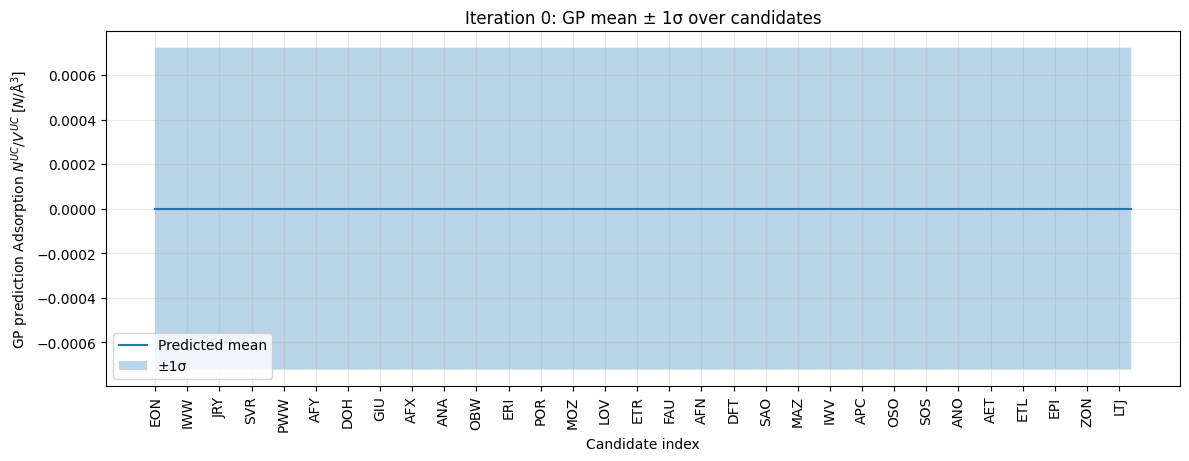

Iteration: 0, Current Best: 4.54e-05


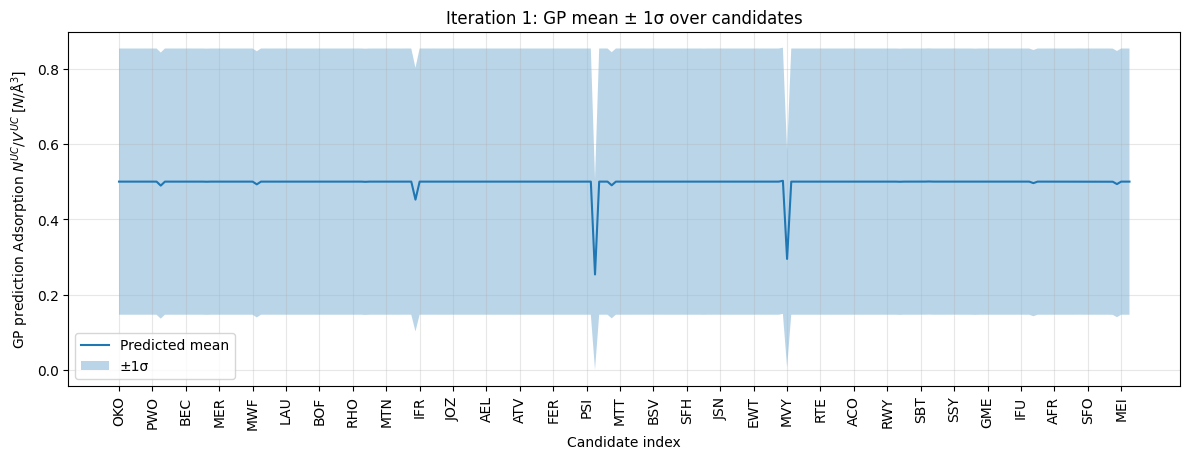

Iteration: 1, Current Best: 1.73e+02


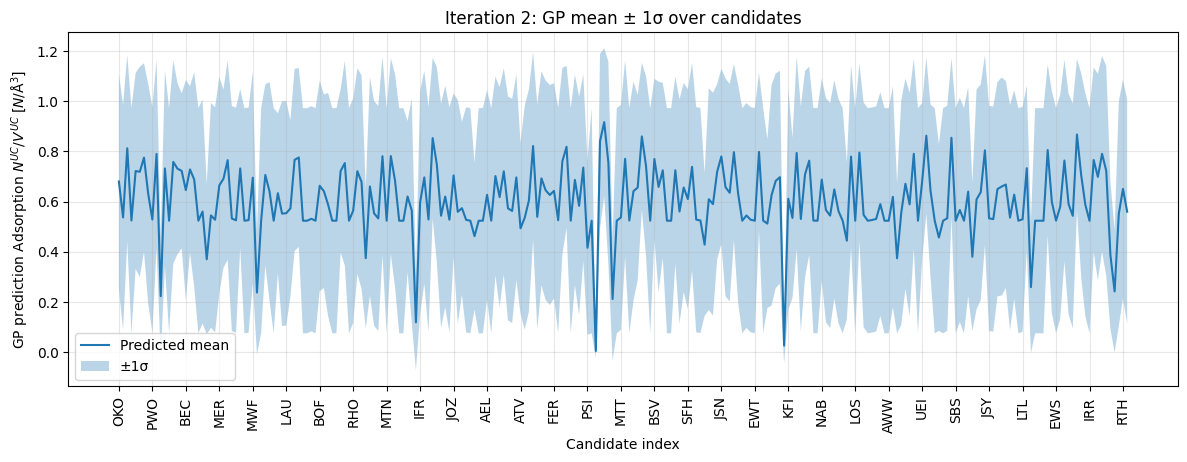

Iteration: 2, Current Best: 1.73e+02


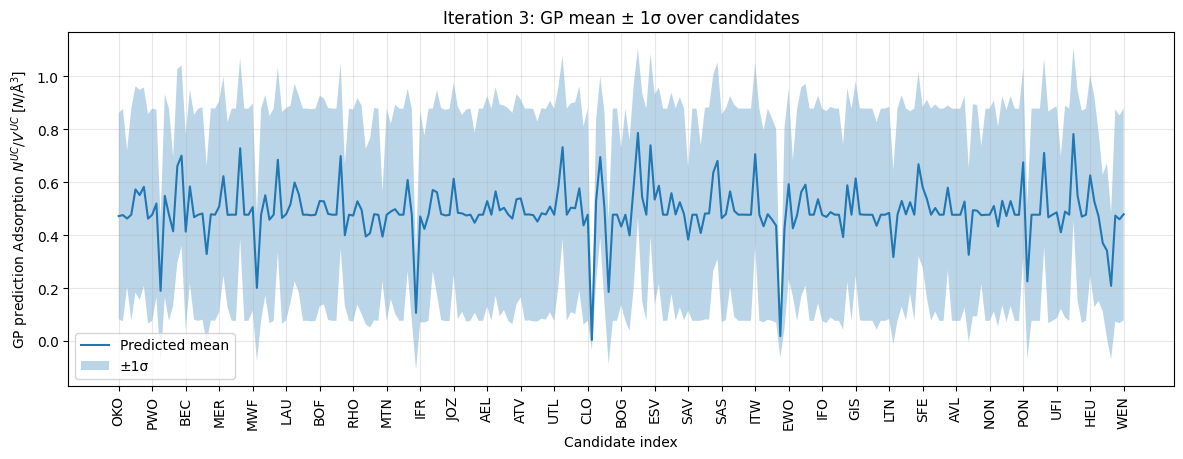

Iteration: 3, Current Best: 1.73e+02


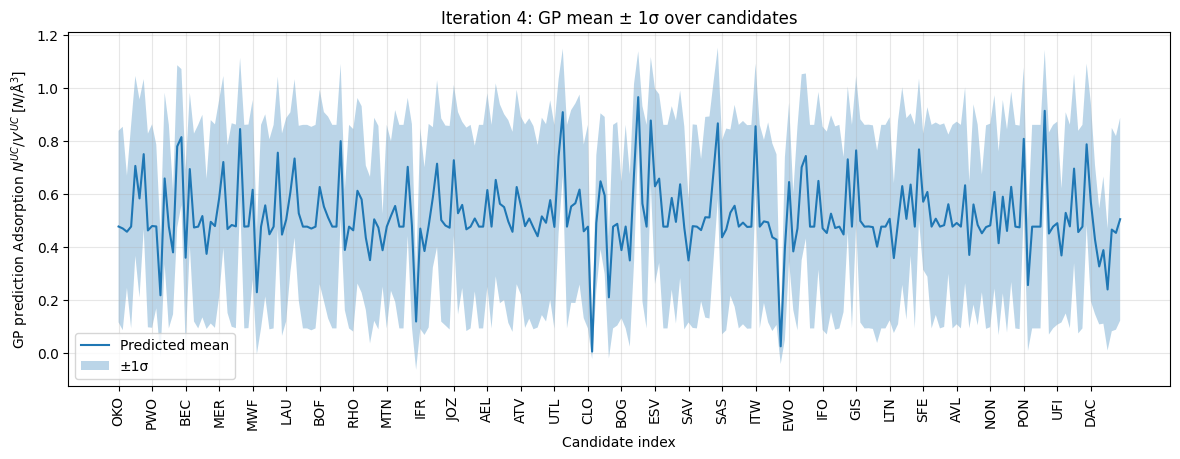

Iteration: 4, Current Best: 1.80e+02


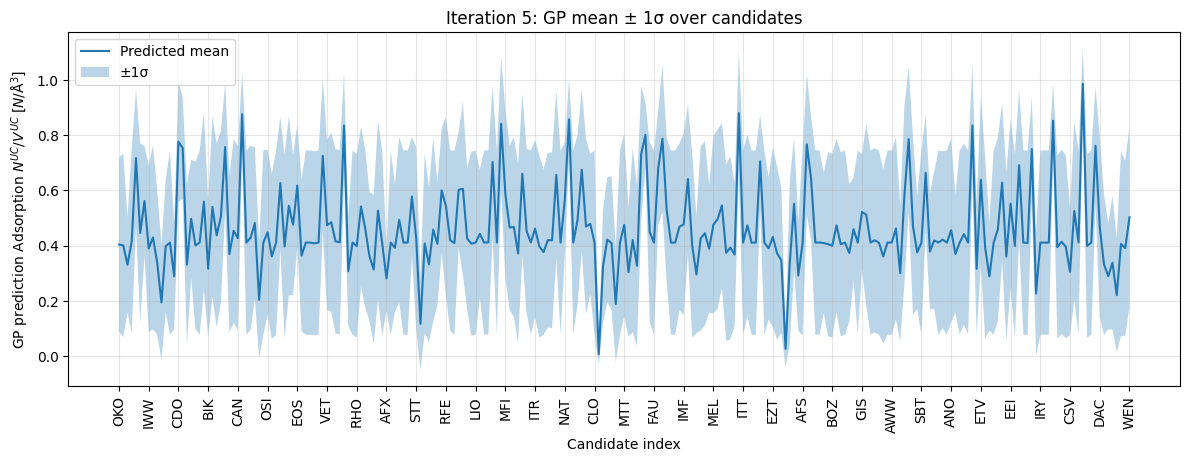

Iteration: 5, Current Best: 2.69e+02


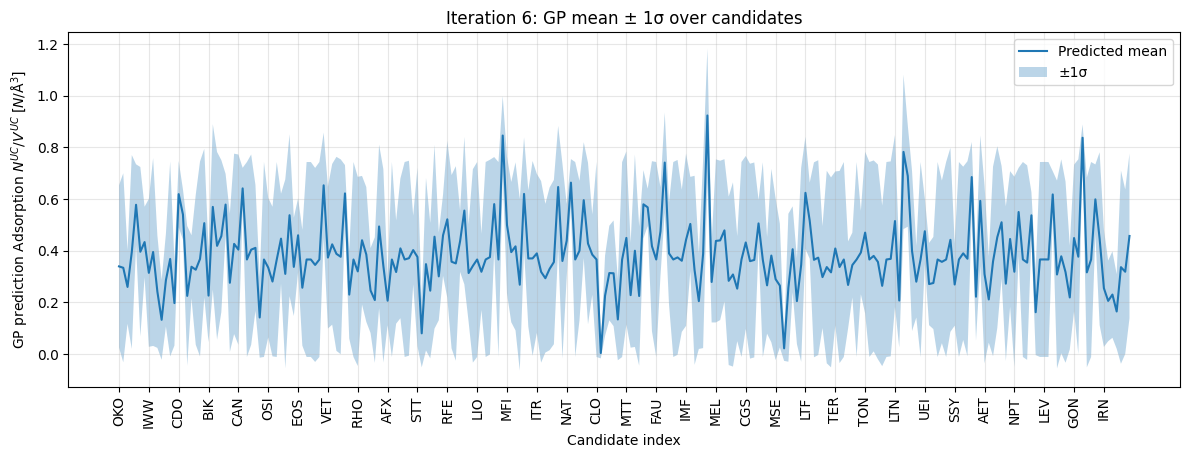

Iteration: 6, Current Best: 3.67e+02


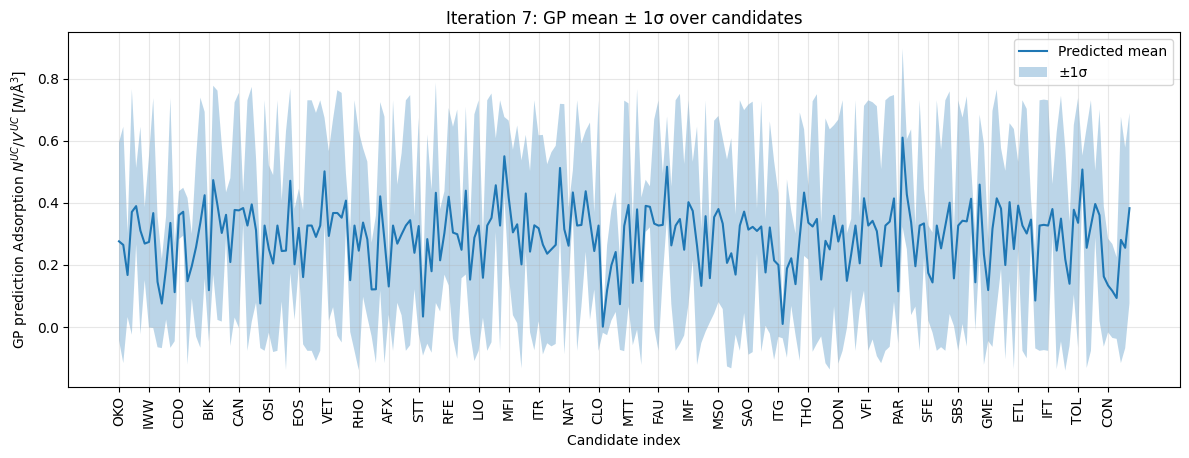

Iteration: 7, Current Best: 5.92e+02


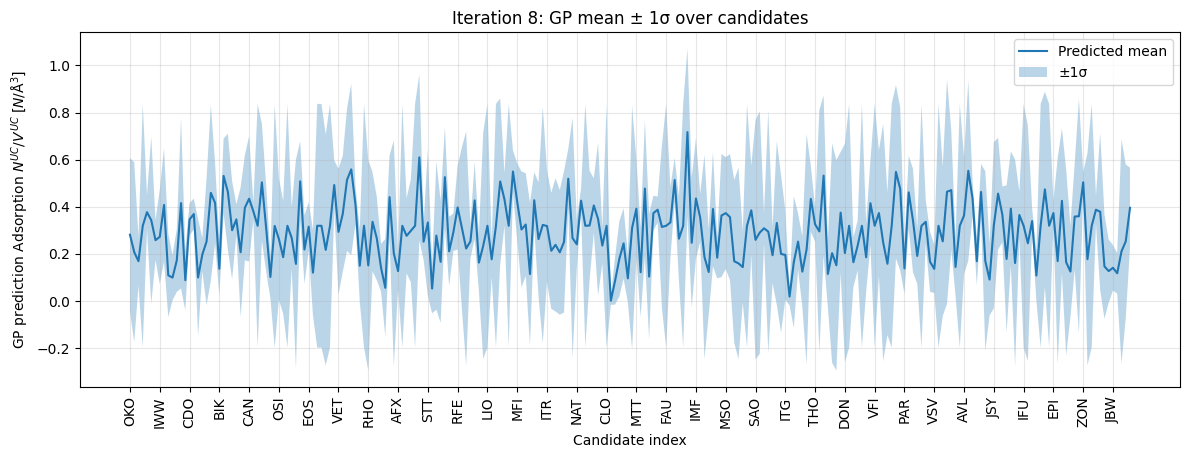

Iteration: 8, Current Best: 5.92e+02


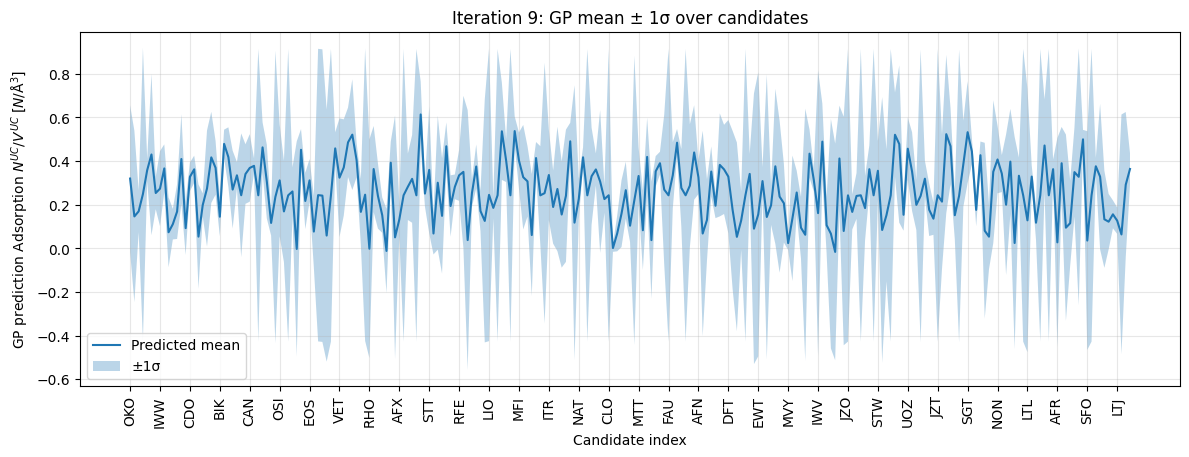

Iteration: 9, Current Best: 5.92e+02


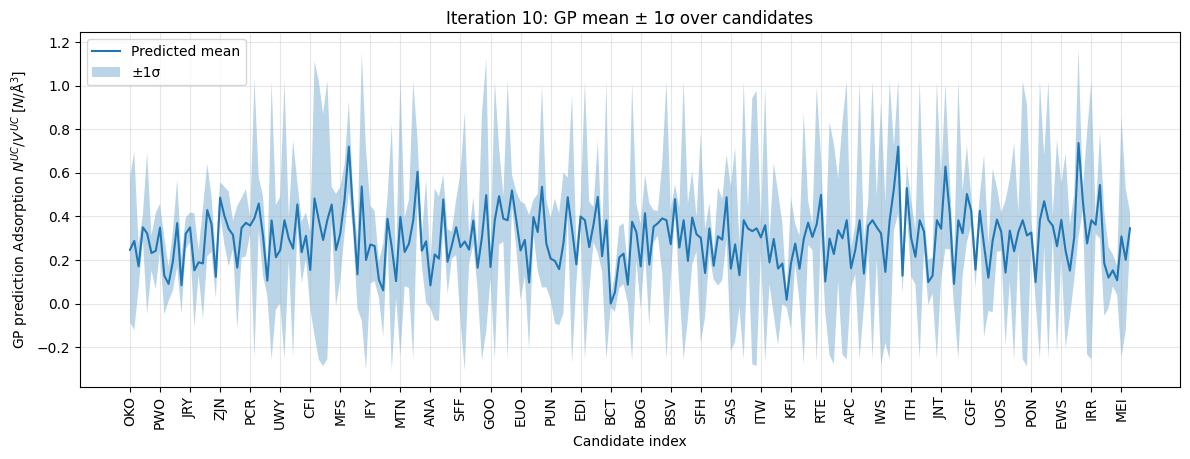

Iteration: 10, Current Best: 6.18e+02


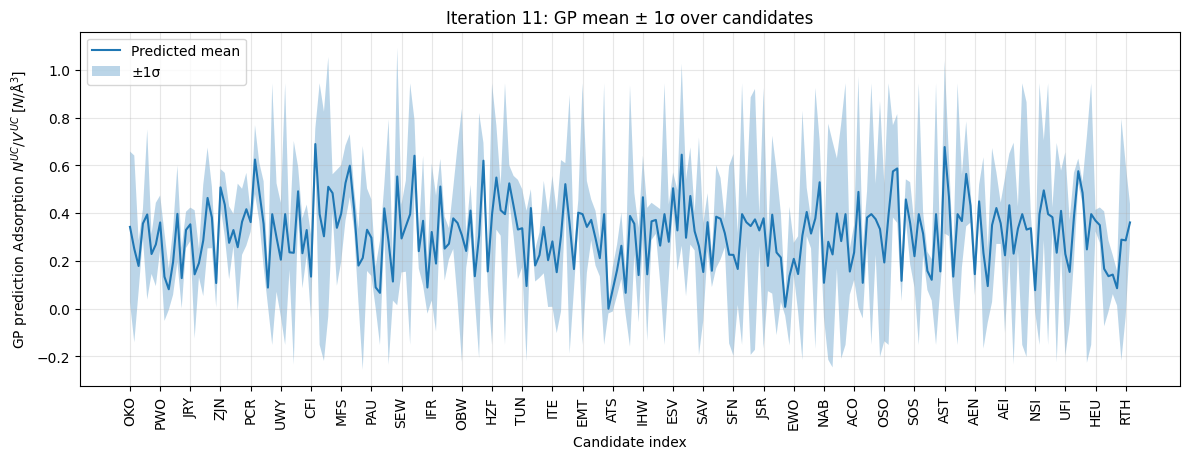

Iteration: 11, Current Best: 6.18e+02


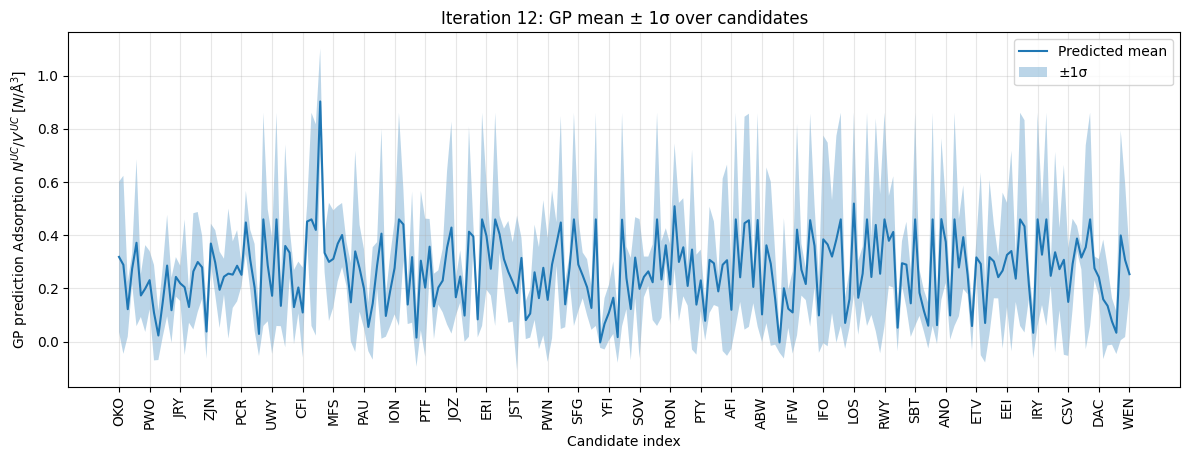

Iteration: 12, Current Best: 9.13e+02


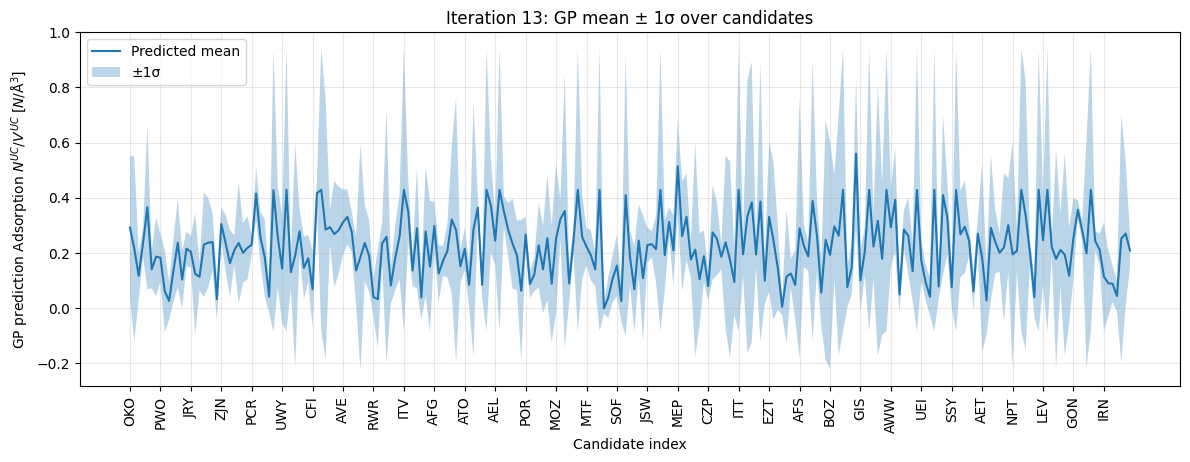

Iteration: 13, Current Best: 1.01e+03


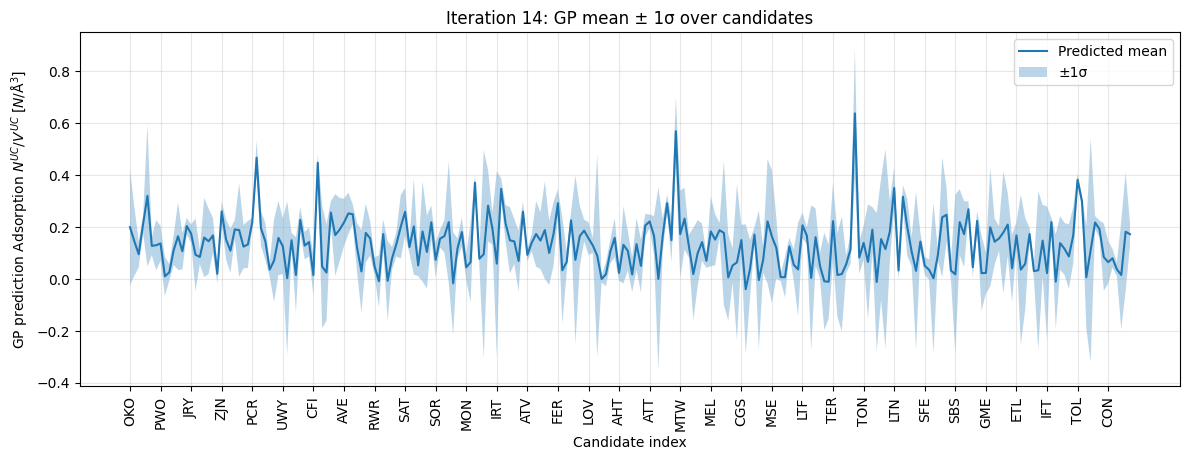

Iteration: 14, Current Best: 1.01e+03


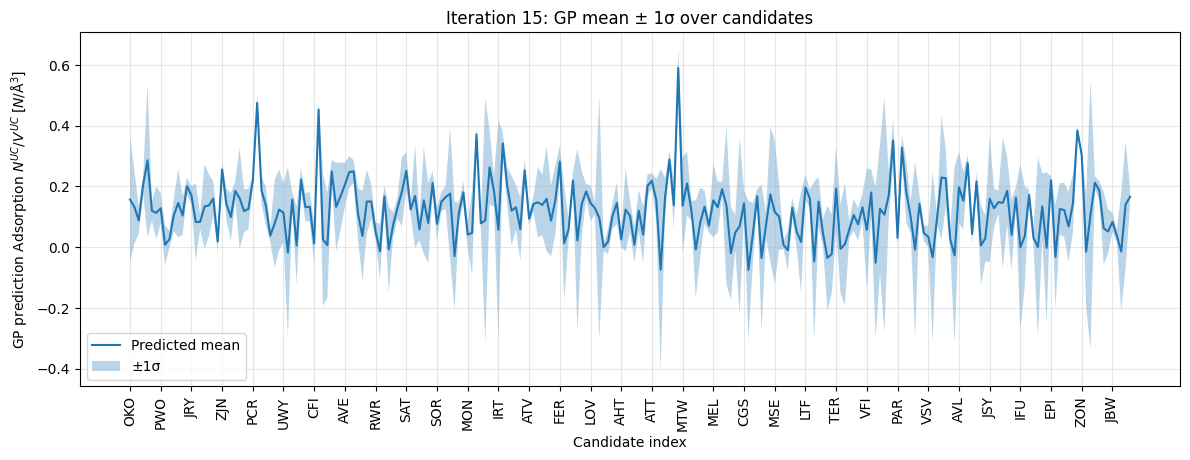

Iteration: 15, Current Best: 1.01e+03


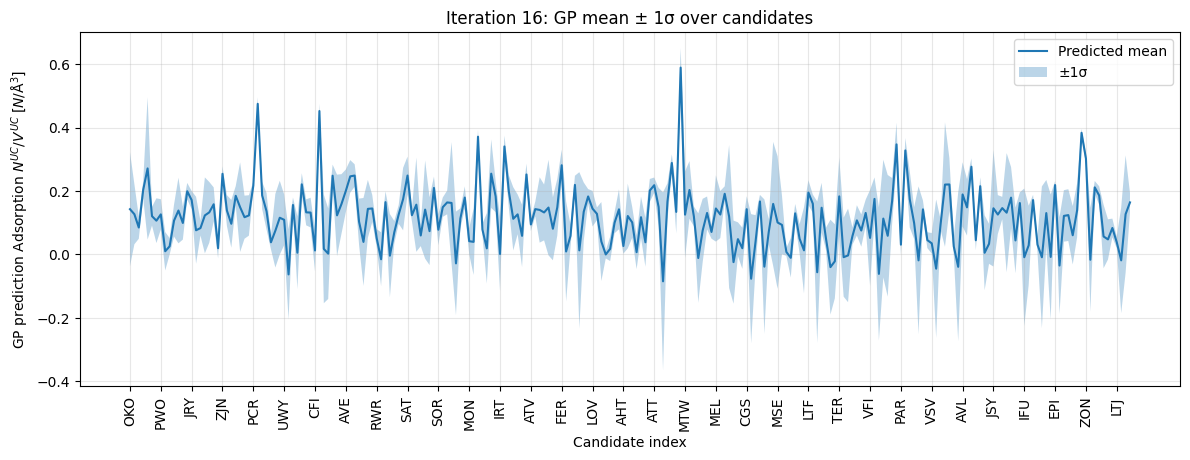

Iteration: 16, Current Best: 1.01e+03


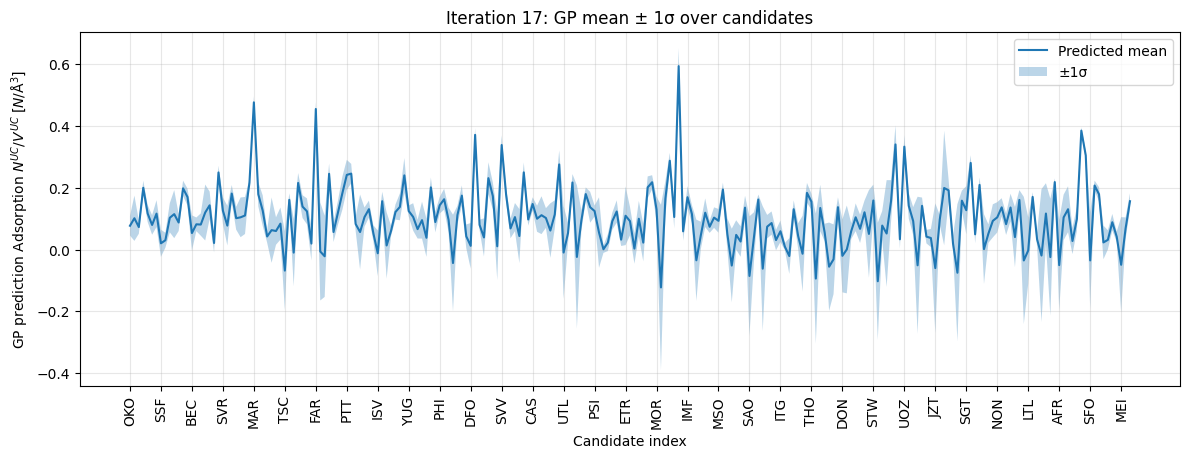

Iteration: 17, Current Best: 1.01e+03


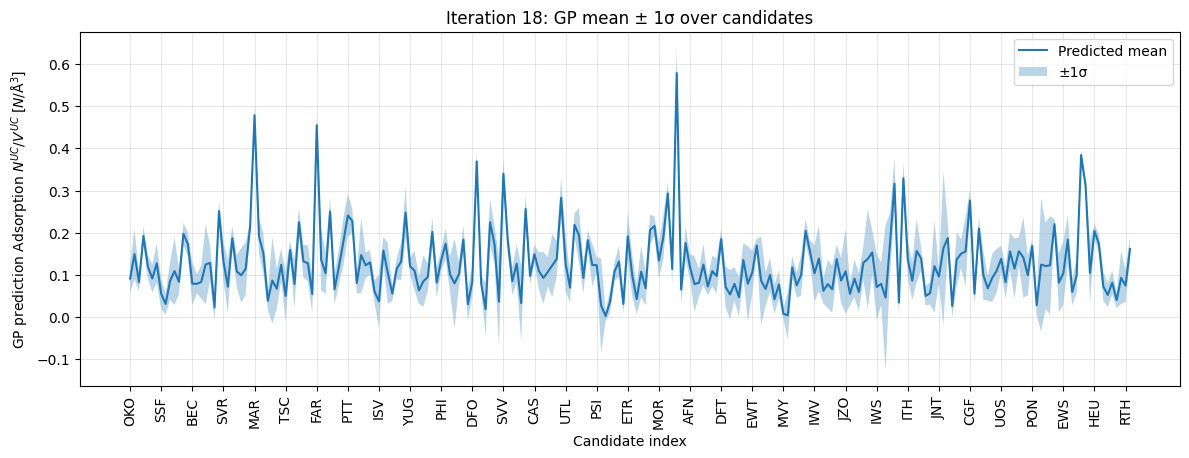

Iteration: 18, Current Best: 1.01e+03


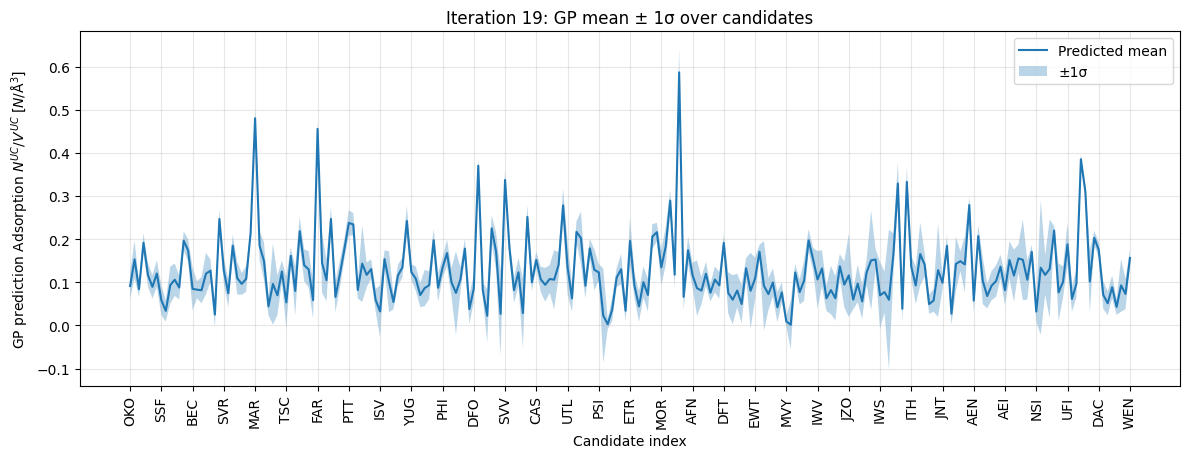

Iteration: 19, Current Best: 1.01e+03


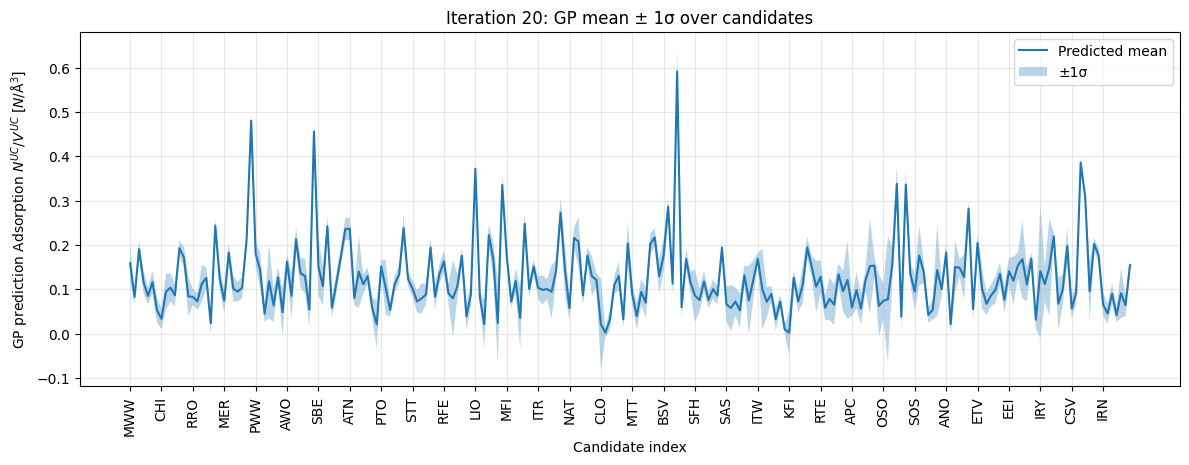

Iteration: 20, Current Best: 1.01e+03


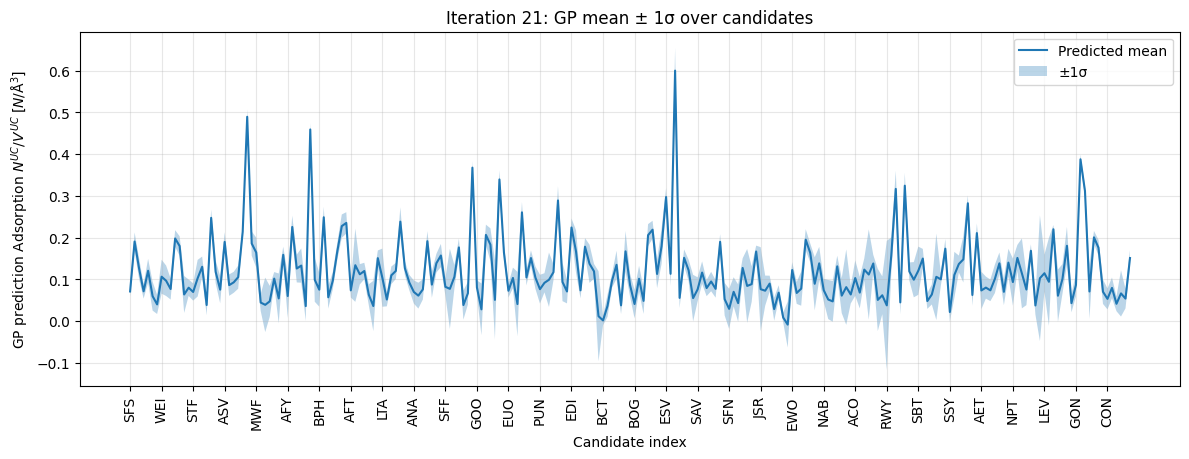

Iteration: 21, Current Best: 1.01e+03


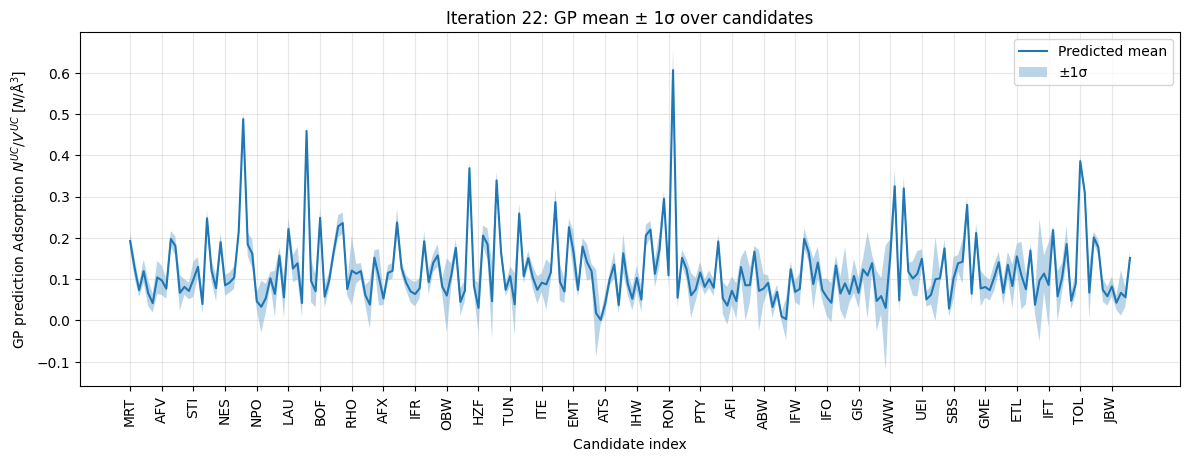

Iteration: 22, Current Best: 1.01e+03
Best value after 24 iterations: 1014.3335944045683


In [20]:
def log_expected_improvement(mean, var, best_f, xi=0.0):
    std = torch.sqrt(var)
    
    # Avoid division by zero
    std_safe = torch.clamp(std, min=1e-9)
    
    # Standardized improvement
    z = (mean - best_f - xi) / std_safe
    
    # Normal distribution
    normal = Normal(torch.zeros_like(z), torch.ones_like(z))
    
    # Calculate log EI using log-sum-exp trick for numerical stability
    # EI = std * (z * Phi(z) + phi(z))
    # where Phi is CDF and phi is PDF
    
    cdf = normal.cdf(z)
    pdf = torch.exp(normal.log_prob(z))
    
    # For numerical stability, handle cases where std is very small
    ei = std * (z * cdf + pdf)
    
    # Clamp to avoid log(0)
    ei_safe = torch.clamp(ei, min=1e-10)
    log_ei = torch.log(ei_safe)
    
    return log_ei

candidates = data.copy()
n_candidates = int(len(candidates))
# patiences for convergence criteria
patience = 10 # 10 trials without changing the best value to interrupt search

# select initial number of worst (=smalles adsorpted amount?)
n_initial = 1
initial_indices = candidates.nsmallest(n_initial, label).index

#n_initial = max(1, min(10, n_candidates - 1))
#initial_indices = candidates.sample(
#    n=n_initial,
#    replace=False      # wichtig: kein Zurücklegen
#).index

print(f"Initial selections:")
for idx in initial_indices:
    print(f"  Index={idx}, Structure={candidates.loc[idx].structure_name}, {label}={candidates.loc[idx][label]:.2e}")

# Transfer entries from candidates to selection
selected = candidates.loc[initial_indices]
candidates = candidates.drop(initial_indices)
best = [selected[label].max()]

for i in range(100):
    if len(best) >= patience:
        if len(np.unique(best[-patience:])) == 1:
            break
        
    feature_transformer = MinMaxScaler()
    label_transformer = MinMaxScaler()

    train_x = torch.tensor(feature_transformer.fit_transform(selected[feature_columns].values))
    train_y = torch.tensor(label_transformer.fit_transform(selected[[label]].values)).flatten()    
    
    test_x = torch.tensor(feature_transformer.transform(candidates[feature_columns].values))

    model, likelihood, _ = train_gp(train_x, train_y, 250)
    with torch.no_grad():
        prediction = model(test_x)
        mean, var = prediction.mean, prediction.variance

    plot_gp_mean_with_uncertainty(candidates, mean, var, iteration=i, label=label, save=True)

    # Get the best observed value (in transformed space)
    best_f = train_y.max()
    
    # Calculate log expected improvement
    log_ei = log_expected_improvement(mean, var, best_f, 0.1)
    
    # Select the next point with highest EI
    index = torch.argmax(log_ei).item()
    best.append(selected[label].max())
    print(f"Iteration: {i}, Current Best: {selected[label].max():.2e}")
    selected = pd.concat([selected, candidates.iloc[[index]]])
    candidates = candidates.drop(candidates.index[index])

print(f"Best value after {len(best)} iterations: {best[-1]}")

#plot_gp_results(candidates, mean_np, std_np, ei_np, pi_np, iteration=20, label=label)


Text(0.5, 0, 'Iterations')

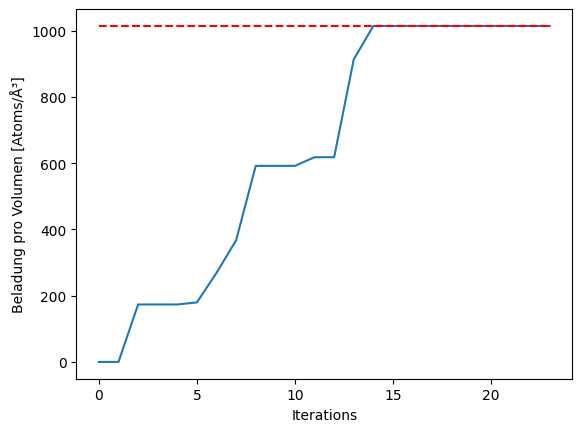

In [21]:
plt.plot(best)
plt.hlines(data[label].max(), 0, len(best)-1, colors='r', linestyles='dashed')
plt.ylabel("Beladung pro Volumen [Atoms/Å³]")
plt.xlabel("Iterations")

In [22]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from torch.distributions import Normal

# -----------------------------
# Acquisition functions
# -----------------------------
def log_expected_improvement(mean, var, best_f, xi=0.0):
    std = torch.sqrt(var)
    std_safe = torch.clamp(std, min=1e-9)
    z = (mean - best_f - xi) / std_safe

    normal = Normal(torch.zeros_like(z), torch.ones_like(z))
    cdf = normal.cdf(z)
    pdf = torch.exp(normal.log_prob(z))

    ei = std * (z * cdf + pdf)
    ei_safe = torch.clamp(ei, min=1e-10)
    return torch.log(ei_safe)

def ucb(mean, var, beta=2.0):
    std = torch.sqrt(var)
    return mean + beta * std


# -----------------------------
# Better initial selection
# -----------------------------
def initial_indices_kmeans(df, feature_columns, n_initial, random_state=0):
    """Pick diverse initial points via KMeans (closest point to each centroid)."""
    X = df[feature_columns].values
    if len(df) <= n_initial:
        return df.index

    km = KMeans(n_clusters=n_initial, n_init=1, random_state=random_state)
    labels = km.fit_predict(X)
    centers = km.cluster_centers_

    picked = []
    for k in range(n_initial):
        members = np.where(labels == k)[0]
        if len(members) == 0:
            continue
        # closest member to centroid
        d = np.linalg.norm(X[members] - centers[k], axis=1)
        picked.append(df.index[members[np.argmin(d)]])
    # fallback if some clusters empty
    if len(picked) < n_initial:
        rest = df.index.difference(picked)
        extra = np.random.default_rng(random_state).choice(rest, size=(n_initial - len(picked)), replace=False)
        picked.extend(list(extra))
    return pd.Index(picked)


# -----------------------------
# BO setup
# -----------------------------
candidates = data.copy()
n_candidates = int(len(candidates))

max_iter = 100
patience = 10

# Choose init strategy: "kmeans" or "random"
init = "kmeans"

# Choose acquisition: "ei" or "ucb"
acq = "ucb"

# Exploration settings for EI
xi_mode = "anneal"   # "const" or "anneal"
xi0 = 0.05           # start (in SCALED y-space) for anneal, or constant if xi_mode="const"
xi_min = 0.005       # floor for anneal

# Exploration settings for UCB
beta_mode = "anneal"  # "const" or "anneal"
beta0 = 3.0
beta_min = 1.0

# Initial points
n_initial = max(3, min(10, n_candidates - 1))  # a bit safer than 1

# -----------------------------
# Global scaling (FIX)
# Fit scalers ONCE to avoid drifting scales during BO
# -----------------------------
feature_transformer = MinMaxScaler()
label_transformer = MinMaxScaler()

feature_transformer.fit(candidates[feature_columns].values)
label_transformer.fit(candidates[[label]].values)

# -----------------------------
# Initial selection (diverse)
# -----------------------------
if init == "kmeans":
    initial_indices = initial_indices_kmeans(candidates, feature_columns, n_initial, random_state=0)
else:
    initial_indices = candidates.sample(n=n_initial, replace=False, random_state=0).index

print("Initial selections:")
for idx in initial_indices:
    print(f"  Index={idx}, Structure={candidates.loc[idx].structure_name}, {label}={candidates.loc[idx][label]:.2e}")

selected = candidates.loc[initial_indices].copy()
candidates = candidates.drop(initial_indices).copy()

best = [float(selected[label].max())]


# -----------------------------
# BO loop
# -----------------------------
for i in range(max_iter):

    # Early stopping (robust-ish): if best hasn't changed (rounded) for patience iters
    if len(best) >= patience and len(np.unique(np.round(best[-patience:], 12))) == 1:
        print(f"Early stopping at iteration {i} (no improvement in last {patience}).")
        break

    # Build train/test (GLOBAL scaling)
    train_x = torch.tensor(
        feature_transformer.transform(selected[feature_columns].values),
        dtype=torch.float32
    )
    train_y = torch.tensor(
        label_transformer.transform(selected[[label]].values),
        dtype=torch.float32
    ).flatten()

    test_x = torch.tensor(
        feature_transformer.transform(candidates[feature_columns].values),
        dtype=torch.float32
    )

    # Train GP
    model, likelihood, _ = train_gp(train_x, train_y, 250)

    with torch.no_grad():
        pred = model(test_x)
        mean, var = pred.mean, pred.variance

    best_f = train_y.max()

    # Exploration schedule
    if acq == "ei":
        if xi_mode == "anneal":
            # decay over iterations: xi = max(xi_min, xi0 * 0.95^i)
            xi = max(xi_min, xi0 * (0.95 ** i))
        else:
            xi = xi0

        score = log_expected_improvement(mean, var, best_f, xi=xi)
        pick = torch.argmax(score).item()

        # optional: debug print top-3 EI
        # topk = torch.topk(score, k=min(3, len(score))).indices.cpu().numpy()
        # print("Top EI:", [(candidates.iloc[j].name, float(torch.exp(score[j]).cpu())) for j in topk])

    elif acq == "ucb":
        if beta_mode == "anneal":
            beta = max(beta_min, beta0 * (0.97 ** i))
        else:
            beta = beta0

        score = ucb(mean, var, beta=beta)
        pick = torch.argmax(score).item()

        # optional: debug print top-3 UCB
        # topk = torch.topk(score, k=min(3, len(score))).indices.cpu().numpy()
        # print("Top UCB:", [(candidates.iloc[j].name, float(score[j].cpu())) for j in topk])

    else:
        raise ValueError("acq must be 'ei' or 'ucb'")

    # Logging BEFORE update (current)
    current_best = float(selected[label].max())
    picked_row = candidates.iloc[pick]
    picked_true = float(picked_row[label])
    picked_name = picked_row["structure_name"]

    print(
        f"Iter {i:03d} | best={current_best:.3e} | pick={picked_name} | true={picked_true:.3e} | "
        f"acq={acq} " +
        (f"(xi={xi:.3g})" if acq == "ei" else f"(beta={beta:.3g})")
    )

    # Update sets
    selected = pd.concat([selected, candidates.iloc[[pick]]])
    candidates = candidates.drop(candidates.index[pick])

    # FIX: best AFTER update
    best.append(float(selected[label].max()))

print(f"Best value after {len(best)-1} iterations: {best[-1]:.6g}")


Initial selections:
  Index=602, Structure=STI, beladung_pro_vol=1.24e+02
  Index=5762, Structure=ITH, beladung_pro_vol=9.28e+01
  Index=4532, Structure=ITT, beladung_pro_vol=3.85e+01
  Index=7292, Structure=RTH, beladung_pro_vol=7.84e+01
  Index=6752, Structure=EPI, beladung_pro_vol=2.16e+02
  Index=92, Structure=SFS, beladung_pro_vol=8.20e+01
  Index=5192, Structure=BOZ, beladung_pro_vol=4.07e+01
  Index=2642, Structure=HZF, beladung_pro_vol=1.12e+01
  Index=1412, Structure=SBE, beladung_pro_vol=5.71e+01
  Index=7202, Structure=JBW, beladung_pro_vol=2.14e+01
Iter 000 | best=2.157e+02 | pick=LIT | true=4.538e-05 | acq=ucb (beta=3)
Iter 001 | best=2.157e+02 | pick=LOS | true=7.398e+02 | acq=ucb (beta=2.91)
Iter 002 | best=7.398e+02 | pick=MTN | true=9.134e+02 | acq=ucb (beta=2.82)
Iter 003 | best=9.134e+02 | pick=DOH | true=1.014e+03 | acq=ucb (beta=2.74)
Iter 004 | best=1.014e+03 | pick=DDR | true=6.180e+02 | acq=ucb (beta=2.66)
Iter 005 | best=1.014e+03 | pick=SOD | true=5.919e+02 | 

Text(0.5, 0, 'Iterations')

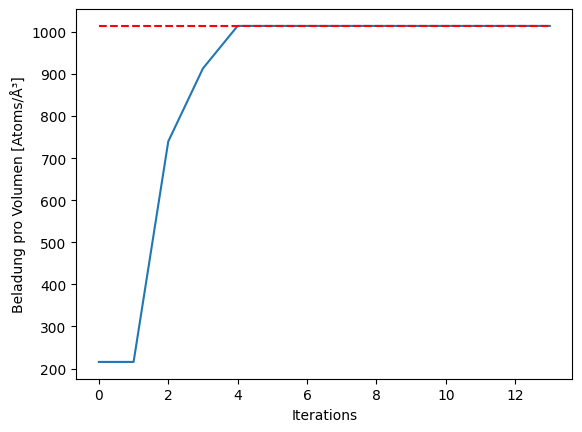

In [23]:
plt.plot(best)
plt.hlines(data[label].max(), 0, len(best)-1, colors='r', linestyles='dashed')
plt.ylabel("Beladung pro Volumen [Atoms/Å³]")
plt.xlabel("Iterations")